In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import Spectral
import pickle
from tqdm import tqdm

from matplotlib.backends.backend_pdf import PdfPages
from scipy import signal
import nitime.algorithms as tsa

In [8]:
first_run = False

H_strs = ['0.25', '0.50', '0.75', '0.95']

nt = 1001
to = np.arange(nt)
num_realizations = 100
path_prefix = './new_results/'

# parameters setup for WWZ
ntau = 21    
tau = np.linspace(np.min(to), np.max(to), ntau)  # evenly-spaced time points
dcon = 1/(8*np.pi**2)/1e3  # the delay constant

#freqs = np.linspace(1/1000, 1/2, 200)
wa = Spectral.WaveletAnalysis()
freqs = wa.make_freq_vector(to)

for H_str in H_strs:
    if first_run:
        np.random.seed(2333)

        H = float(H_str)
        %time Xo = [Spectral.fBMsim(N=nt, H=H) for i in range(num_realizations)]
        
        with open(path_prefix+'fBM_realizations-'+H_str+'.pickle', 'wb') as f:
            pickle.dump(Xo, f)
        
        sns.set(style="darkgrid", font_scale=2)
        plt.subplots(figsize=[20, 4])

        for ts in Xo:
            plt.plot(to, ts)
        
    else:
        with open(path_prefix+'fBM_realizations-'+H_str+'.pickle', 'rb') as f:
            Xo = np.asarray(pickle.load(f))
            Xo = wa.preprocess(Xo, standardize=False, detrending=True)  # detrending

            psds = np.ndarray(shape=(num_realizations, np.size(freqs)))
            psds_filter = np.copy(psds)

            for i, ts in enumerate(tqdm(Xo), desc='H = '+H_str + ' running...'):
                psds[i, :] = Spectral.wwz_psd(ts, to, tau, freqs=freqs, freqs_num_percent=1, c=dcon, nproc=8, anti_alias=False)
                psds_filter[i, :] = Spectral.wwz_psd(ts, to, tau, freqs=freqs, freqs_num_percent=1, c=dcon, nproc=8, anti_alias=True)

            with open(path_prefix+'psds-'+H_str+'-detrend.pickle', 'wb') as f:
                pickle.dump((psds, psds_filter), f)

  0%|          | 0/100 [00:00<?, ?it/s]

H = 0.25 running...


  0%|          | 0/100 [00:00<?, ?it/s]

H = 0.50 running...


  0%|          | 0/100 [00:00<?, ?it/s]

H = 0.75 running...


  0%|          | 0/100 [00:00<?, ?it/s]

H = 0.95 running...


100%|██████████| 100/100 [03:56<00:00,  2.36s/it]


In [9]:
H_strs = ['0.25', '0.50', '0.75', '0.95']
freq_ticks = [2, 5, 10, 20, 50, 100, 200, 500, 1000]

nt = 1001
to = np.arange(nt)
num_realizations = 100
path_prefix = './new_results/'

# parameters setup for WWZ
ntau = 21    
tau = np.linspace(np.min(to), np.max(to), ntau)  # evenly-spaced time points
dcon = 1/(8*np.pi**2)/1e3  # the delay constant

#freqs = np.linspace(1/1000, 1/2, 200)
wa = Spectral.WaveletAnalysis()
freqs = wa.make_freq_vector(to)


for k, H_str in enumerate(H_strs):
    #print('H = '+H_str + ' running...')
    
    with open(path_prefix+'fBM_realizations-'+H_str+'.pickle', 'rb') as f:
        Xo = pickle.load(f)
        Xo = np.asarray(Xo)
    
    Xo = wa.preprocess(Xo, standardize=False, detrending=True)  # detrending
    
    freq_periodogram, Pxx_den = signal.periodogram(Xo, 1)
    freq_mtm, psd_mtm, nu = tsa.multi_taper_psd(Xo, adaptive=False, jackknife=False, NW=1, Fs=1)

    with PdfPages(path_prefix+'psds-'+H_str+'.pdf') as pdf:
        with open(path_prefix+'psds-'+H_str+'.pickle', 'rb') as f:
            psds, psds_filter = pickle.load(f)
            
        for i in tqdm(range(num_realizations), desc='H = '+H_str + ' running...'):
            fig = Spectral.plot_psd(psds[i], freqs,
                                    xticks=freq_ticks,
                                    xlim=[np.min(freq_ticks), np.max(freq_ticks)],
                                    label='wwz', ylim=[1e-3, 1e9],
                                    lmstyle='-')

            psd_ana = Spectral.psd_fBM(freqs, to, float(H_str))
            plt.plot(1/freqs, psd_ana, '-', label='analytic')

            plt.plot(1/freq_periodogram[1:], Pxx_den[i, 1:], '-', label='periodogram')

            plt.plot(1/freq_mtm[1:], psd_mtm[i, 1:], '-', label='mtm')

            plt.plot(1/freqs, psds_filter[i], '-', label='wwz filter')

            plt.legend(loc=1)
            pdf.savefig(fig)
            plt.close()

H = 0.95 running...: 100%|██████████| 100/100 [00:38<00:00,  2.80it/s]


In [12]:
H_strs = ['0.25', '0.50', '0.75', '0.95']

nt = 1001
to = np.arange(nt)
num_realizations = 100
path_prefix = './new_results/'

# parameters setup for WWZ
ntau = 21    
tau = np.linspace(np.min(to), np.max(to), ntau)  # evenly-spaced time points
dcon = 1/(8*np.pi**2)/1e3  # the delay constant

#freqs = np.linspace(1/1000, 1/2, 200)
wa = Spectral.WaveletAnalysis()
freqs = wa.make_freq_vector(to)

nh, nr = np.size(H_strs), num_realizations

H_wwz = np.ndarray(shape=(nh, nr))
H_wwz_filter = np.copy(H_wwz)
H_periodogram = np.copy(H_wwz)
H_mtm = np.copy(H_wwz)

fmin, fmax = 1/100, 1/5

for k, H_str in enumerate(H_strs):
    
    with open(path_prefix+'fBM_realizations-'+H_str+'.pickle', 'rb') as f:
        Xo = pickle.load(f)
        Xo = np.asarray(Xo)
    
    freq_periodogram, Pxx_den = signal.periodogram(Xo, 1)
    freq_mtm, psd_mtm, nu = tsa.multi_taper_psd(Xo, adaptive=False, jackknife=False, NW=1, Fs=1)    
    
    with open(path_prefix+'psds-'+H_str+'-detrend.pickle', 'rb') as f:
        psds, psds_filter = pickle.load(f)

    for i in range(nr):
        beta_wwz, _, _, _ = wa.beta_estimation(psds[i], freqs, fmin, fmax)
        H_wwz[k, i] = wa.beta2HurstIndex(beta_wwz)
        
        beta_wwz_filter, _, _, _ = wa.beta_estimation(psds_filter[i], freqs, fmin, fmax)
        H_wwz_filter[k, i] = wa.beta2HurstIndex(beta_wwz_filter)
        
        beta_periodogram, _, _, _ = wa.beta_estimation(Pxx_den[i, 1:], freq_periodogram[1:], fmin, fmax)
        H_periodogram[k, i] = wa.beta2HurstIndex(beta_periodogram)
        
        beta_mtm, _, _, _ = wa.beta_estimation(psd_mtm[i, 1:], freq_mtm[1:], fmin, fmax)
        H_mtm[k, i] = wa.beta2HurstIndex(beta_mtm)

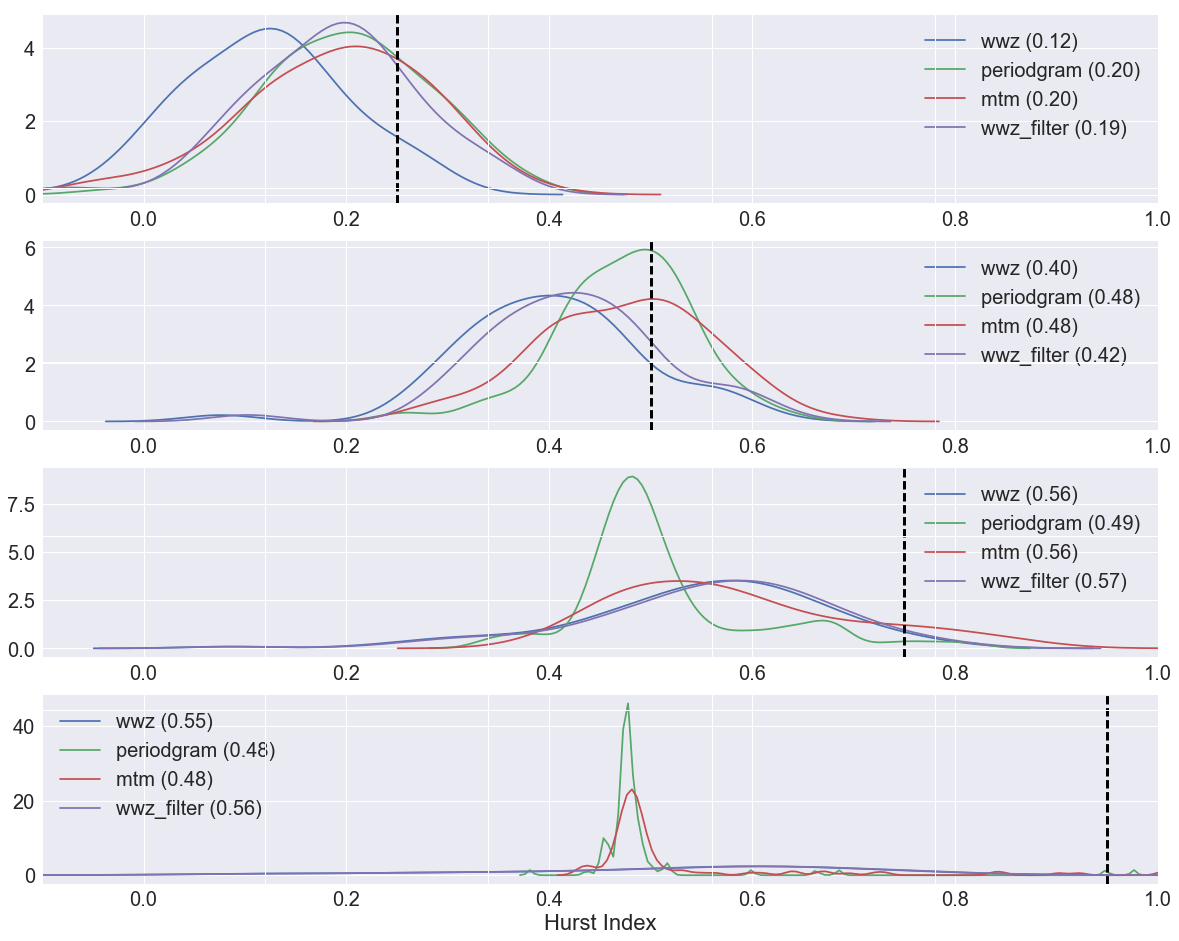

In [14]:
sns.set(style="darkgrid", font_scale=2)

med_wwz = np.median(H_wwz, axis=1)
med_wwz_filter = np.median(H_wwz_filter, axis=1)
med_periodogram = np.median(H_periodogram, axis=1)
med_mtm = np.median(H_mtm, axis=1)

fig, ax = plt.subplots(figsize=[20, 16])

for k, H_str in enumerate(H_strs):
    str_med_wwz = format(med_wwz[k], '.2f')
    str_med_wwz_filter = format(med_wwz_filter[k], '.2f')
    str_med_periodogram = format(med_periodogram[k], '.2f')
    str_med_mtm = format(med_mtm[k], '.2f')
    
    hist = plt.subplot(np.size(H_strs), 1, k+1)
    sns.kdeplot(H_wwz[k, :], label='wwz ('+str_med_wwz+')')
    sns.kdeplot(H_periodogram[k, :], label='periodgram ('+str_med_periodogram+')')
    sns.kdeplot(H_mtm[k, :], label='mtm ('+str_med_mtm+')')
    sns.kdeplot(H_wwz_filter[k, :], label='wwz_filter ('+str_med_wwz_filter+')')
    hist.axvline(x=float(H_str), ymin=0, ymax=1, linewidth=3, color='black', linestyle='--')
    hist.set_xlim([-0.1, 1])
    plt.legend()

#fig.tight_layout()
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
plt.xlabel("Hurst Index")
ax.figure.savefig(path_prefix+'H-comp-detrend.pdf')